# Project2 Lab Notebook (Shawn Kessler, Giles Ochs, Brian Schneider)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import shared_utils as su
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

Workflow Note: To avoid the chaos of notebooks and git we made three separate notebooks, one for each developer. The developer assigned a given notebook was the only person allowed to edit that notebook. Any code that seemed like others might find useful was put into a python library file. Otherwise if it was just a smaller bit of code you could go in and copy and paste what someone else did in their notebook. This worked well and we never had any major git hub merging issues or difficulties. The final lab notebook might be the exception to this rule as we attempt to merge our separate notebooks into a single file.

In [6]:
df = su.read_trip_data()
df.head()

,Trip_ID,Duration,Start_Date,Start_Station,Start_Terminal,End_Date,End_Station,End_Terminal,Bike_#,Subscriber_Type,Zip_Code
0,913460,765,2015-08-31 23:26:00,Harry Bridges Plaza (Ferry Building),50,2015-08-31 23:39:00,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139
1,913459,1036,2015-08-31 23:11:00,San Antonio Shopping Center,31,2015-08-31 23:28:00,Mountain View City Hall,27,35,Subscriber,95032
2,913455,307,2015-08-31 23:13:00,Post at Kearny,47,2015-08-31 23:18:00,2nd at South Park,64,468,Subscriber,94107
3,913454,409,2015-08-31 23:10:00,San Jose City Hall,10,2015-08-31 23:17:00,San Salvador at 1st,8,68,Subscriber,95113
4,913453,789,2015-08-31 23:09:00,Embarcadero at Folsom,51,2015-08-31 23:22:00,Embarcadero at Sansome,60,487,Customer,9069


Basing anything on a customers zip code seems to require some cleaning up of that field. Rather than replace the field values I've opted to create a new column with scrubbed data. This process was challenging because the zip code appeared not have any validation done on it when entered. There were blanks, the text string "nil" numbers with fewer than five digits and extended zip codes with dashes in them. We had wanted to set all invalid zip codes to NaN but that was difficult to do in a straightforward manner because not all of the entries could be represented as numbers. So the cleaning code was taken out of the notebook and moved into our python library so that everyone could easily reference it in seperate notebooks.

In [21]:
trip_data = su.read_trip_data(False)
station_data = su.read_station_data()
su.clean_zip_codes(trip_data)

Doing the join below on zip_code_trip_counts and zip_code_station_counts was problematic until we made the zipcode the index on both dataframes. Prior to making the zip code the index we tried using the "on" parameter to join like this:
zip_code_trip_counts.join(zip_code_station_counts, on="Zip_Code") 
This always failed (even when specifying a left and right post fix for the overlapping Zip_Code column. The documentation made it seem like this should work. After getting the join to work on the zip code indexes we didn't have time to further debug the other technique and so it's still a mystery how to join on something other than the index of two dataframes.

In [22]:
# Counts of how often a customer is from a san francisco zip code
zip_code_trip_counts = su.get_trip_counts_by_zip_code(trip_data)

# Counts of how many stations are in a zip code
zip_code_station_counts = su.get_station_counts_by_zip_code(station_data)
# originally tried a two different filtering techniques. Not sure which is better.
#sf_only_customer_trip_data = trip_data.groupby("Clean_Zip_Code").filter(lambda x: x.name in su.SF_ZIP_CODES)
#sf_only_customer_trip_data = trip_data[trip_data.Clean_Zip_Code.map(lambda x : x in su.SF_ZIP_CODES)]

# why couldn't I reset indexes and do: zip_code_trip_counts.join(zip_code_station_counts, on="Zip_Code") 
trip_and_station_counts = zip_code_trip_counts.join(zip_code_station_counts)
trip_and_station_counts.fillna(0, inplace=True)

Our first graph! Here we had to make some business decision about how to represent rides since they are not directly representing in the data. Each trip has a rider type and their home zip code but no unique ids for the riders. We decide that the number of trips would likely be proportial to the number of riders and worked with that. Below we scale the number of trips down by 1000 to represent a rider count and to allow us to graph that number along with station and bike counts without the rider count being so big that it would be hard to read the counts for the bikes and stations.

From a technical standpoint the most unexpected part was that we need to adjust the bottom of our graphs because when they are saved a file they our x-axis label was getting cut off. We thank Google for its contribution to our success.

We also struggled making each zip code have two bars instead of a single one. We eventually settled on overlaying the two bars but another good option that we never did figure out was how to put to bars side by side if they're coming from two different dataframes.

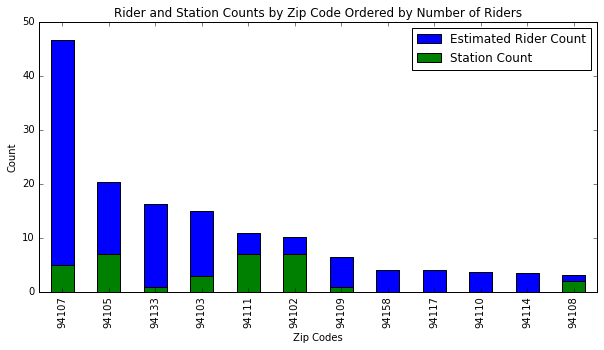

In [23]:
graphable_data = trip_and_station_counts.head(12).copy()
graphable_data.Trip_Count = graphable_data.Trip_Count / 1000
graphable_data.index = [int(x) for x in graphable_data.index]
ax = graphable_data.Trip_Count.plot(kind="bar", label="Estimated Rider Count", legend=True, figsize=(10,5),
                                    title="Rider and Station Counts by Zip Code Ordered by Number of Riders")
graphable_data.Station_Count.plot(kind="bar", label="Station Count", color="Green", legend=True)
ax.set_xlabel("Zip Codes")
ax.set_ylabel("Count")
# prevents the x label from getting cut off in png file
plt.gcf().subplots_adjust(bottom=0.15)
fig = ax.get_figure()
fig.savefig('trips_no_stations.png')

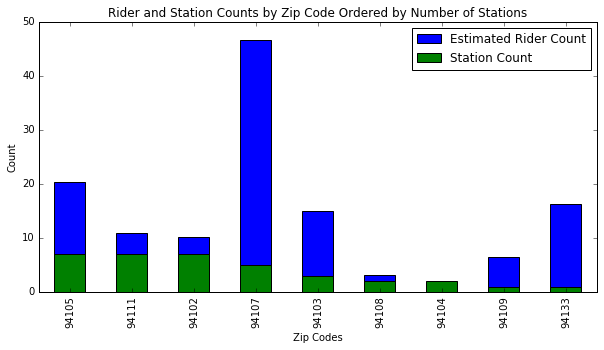

In [24]:
graphable_data = trip_and_station_counts.sort_values("Station_Count", ascending=False).head(9).copy()
graphable_data.Trip_Count = graphable_data.Trip_Count / 1000
graphable_data.index = [int(x) for x in graphable_data.index]
ax = graphable_data.Trip_Count.plot(kind="bar", label="Estimated Rider Count", legend=True, figsize=(10,5),
                                    title="Rider and Station Counts by Zip Code Ordered by Number of Stations")
graphable_data.Station_Count.plot(kind="bar", label="Station Count", color="Green", legend=True)
ax.set_xlabel("Zip Codes")
ax.set_ylabel("Count")
plt.gcf().subplots_adjust(bottom=0.15)
fig = ax.get_figure()
fig.savefig('ordered_by_station_count.png')

Interestingly, during analysis it was often a lot easier to understand the data when looking at it in table form, especially as numbers approached zero, or to really see small differences (like seeing 1 vs 2 is hard to do when your dealing with a axis that is 50 tall.

In [25]:
graphable_data

,Trip_Count,Station_Count
94105,20.311,7
94111,10.960,7
94102,10.150,7
94107,46.629,5
94103,14.983,3
94108,3.120,2
94104,1.359,2
94109,6.413,1
94133,16.246,1


We made an attempt to convert the longitute and latitude data in the stations data set to zip codes but failed to find a great source. The US Postal Service offered a mapping (http://www.unitedstateszipcodes.org/zip-code-database/) but as you can see below it would either result in no zip code for a given lat and long combo or more than one zip code such that it only was prepopulating one or two of the stations we were most interested in.
We spent more time messing with this data set than it took to eventually just fill in by hand the 15 or so zip codes we really cared about. Therefore the station data csv file in our zip file has been handedited to include that data.

In [26]:
# some code figuring out how to get a single zip code
zip_df = su.read_zip_code_data()
zip_df[(zip_df.latitude == 37.79) & (zip_df.longitude == -122.39) & (zip_df.type=='STANDARD')]

,zip,type,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,latitude,longitude,world_region,country,decommissioned,estimated_population,notes
39607,94111,STANDARD,San Francisco,NaN,NaN,CA,San Francisco County,America/Los_Angeles,415510650,37.79,-122.39,NaN,US,0,3905,NaN


In [27]:
# Attempt to get long and lat to zip code from us postal service data
def proccess_station_row(row):  
    df = zip_df[(zip_df.latitude == round(row.lat,2)) & (zip_df.longitude == round(row.long, 2)) & (zip_df.type=='STANDARD')]
    if len(df) == 1:
        result = df.zip.iloc[0]
    else:
        result = np.NaN
    return result

station_data.apply(proccess_station_row, axis=1).head(10)


0      NaN
1    95113
2    95113
3    95113
4      NaN
5    95113
6    95113
7      NaN
8      NaN
9      NaN
dtype: float64

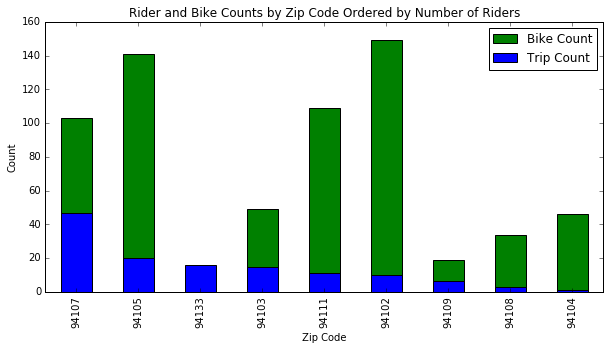

In [28]:
zip_code_bike_counts = su.get_bike_counts_by_zip_code(station_data)
zip_code_trip_counts.index = [int(x) for x in zip_code_trip_counts.index]
graphable_data = zip_code_bike_counts.join(zip_code_trip_counts)
graphable_data.sort_values("Trip_Count", ascending=False, inplace=True)
graphable_data.Trip_Count = graphable_data.Trip_Count / 1000
ax = graphable_data.dockcount.plot(kind="bar", color="Green", legend=True, label="Bike Count", figsize=(10,5),
                                  title="Rider and Bike Counts by Zip Code Ordered by Number of Riders")
graphable_data.Trip_Count.plot(kind="bar", color="Blue", legend=True, label="Trip Count")
ax.set_xlabel("Zip Code")
ax.set_ylabel("Count")
plt.gcf().subplots_adjust(bottom=0.15)
fig = ax.get_figure()
fig.savefig('bikes_count_by_zip_code.png')

In [39]:
subscribers = df[df['Subscriber_Type'] == 'Subscriber'].copy()
customers = df[df['Subscriber_Type'] == 'Customer'].copy()
subscribers['Full_Route'] = subscribers['Start_Station'] + " & " + subscribers['End_Station']
subscribers["date"] = subscribers["Start_Date"].map(pd.Timestamp.date)
customers["date"] = customers["Start_Date"].map(pd.Timestamp.date)
subscribers["hour"] = subscribers["Start_Date"].map(lambda x: x.hour)
customers["hour"] = customers["Start_Date"].map(lambda x: x.hour)

We initially tried to understand route behavior. How does volume change, day-to-day? Which stations do riders start and stop from? When do people tend to travel? Are there particular routes that are especially popular, that may require us to think about those stations differently?

What we learned is that behavior is surprisingly predictable.

Below you'll find how frequently riders ride. Almost each week rider volume hits the same peak in routes (especially the case for subscribers). On holidays (see: Thanksgiving, Christmas), subscribers -- as we'd suspect -- don't tend to ride as much. It turns out, bike share subscribers are by-and-large, commuters.

With this inquiry, we would like to be able to go deeper, to understand subscribers and customers by user ID. Are these the same people riding the same volume every day? Or is there a shift -- are new subscribers taking the place of old? We can't really get at those questions here, because the data isn't available to us.

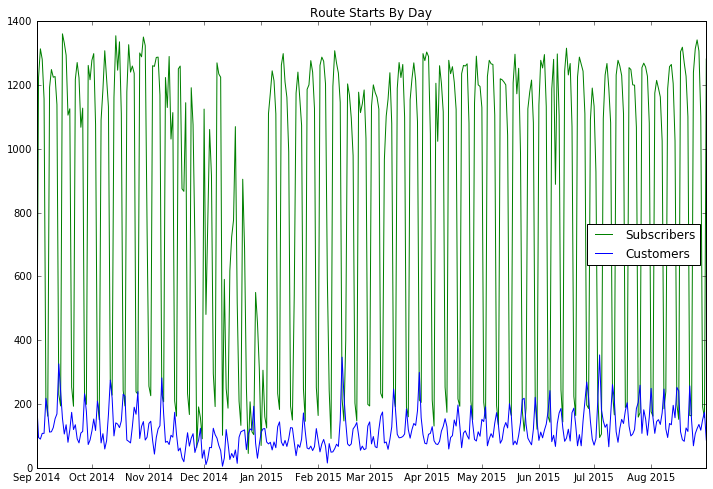

In [35]:
subscribers['date'].value_counts().plot(figsize = (12,8), legend=True, color="Green", label='Subscribers', title='Route Starts By Day')
customers['date'].value_counts().plot(figsize = (12,8), legend=True, label='Customers')

We learned that subscribers tend to travel from commuter hubs (Caltrain, Ferry Building) to popular company sites (7th & Townsend, for example, is where Adobe, Zynga, Thumbtack, and many other relevant companies reside).

We initially intended to map out these routes, but that ended up beyond the scope of the assignment.

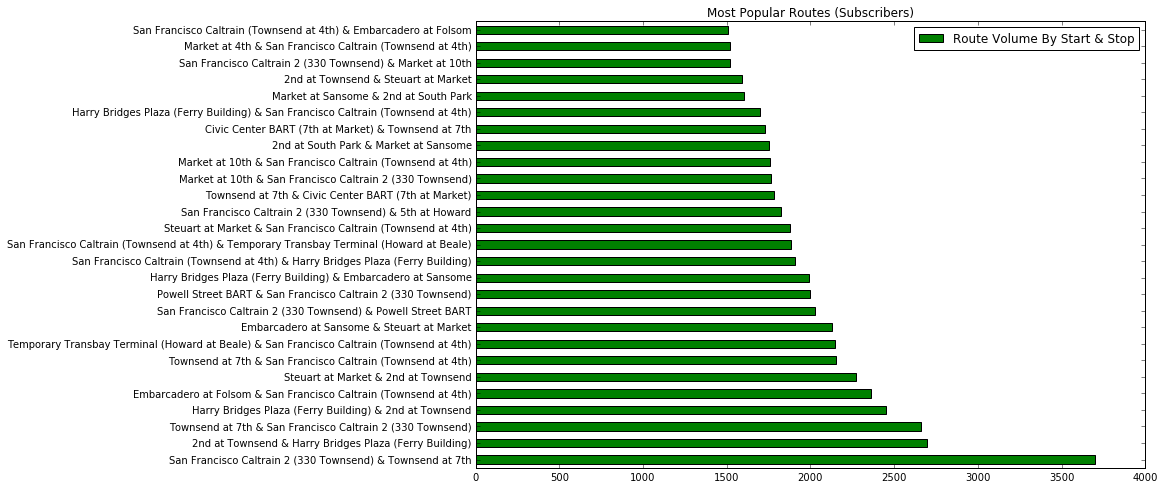

In [36]:
subscribers['Full_Route'].value_counts()[subscribers['Full_Route'].value_counts() > 1500].plot(kind="barh", figsize=(12,8), title="Most Popular Routes (Subscribers)", color='Green', legend=True, label="Route Volume By Start & Stop")

We learned that riders tend to ride during rush hour windows -- mornings before work, and evenings after work. Customers tend to ride in the early afternoon.

The biggest challenge with getting this data in the correct format dealt mostly with datetime conversion -- we reference both date and hour, but both took awhile to get to.

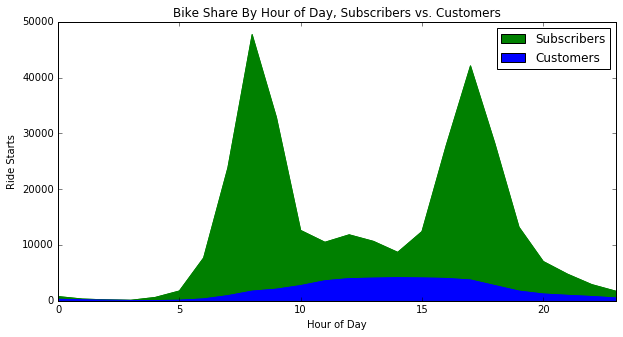

In [37]:
ax2 = subscribers.hour.value_counts().sort_index().plot(figsize=(10,5), kind = "area", color='Green', legend=True, title="Bike Share By Hour of Day, Subscribers vs. Customers", label="Subscribers")
bd2 = customers.hour.value_counts().sort_index().plot(figsize=(10,5), kind = "area", legend=True, label="Customers")

ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Ride Starts")
fig = ax2.get_figure()
fig.savefig('ridersByHour.png')

In [3]:
status = pd.read_csv('/Users/gochs/Documents/MIDS/Python_Bridge/Project_2/Data Sets/babs_open_data_year_1/201402_babs_open_data/201402_status_data.csv')
status.head()
#will need to be changed to remote address

,station_id,bikes_available,docks_available,time
0,2,2,25,2013/08/29 12:06:01
1,2,2,25,2013/08/29 12:07:01
2,2,2,25,2013/08/29 12:08:01
3,2,2,25,2013/08/29 12:09:01
4,2,2,25,2013/08/29 12:10:01


In [7]:
start = df.groupby('Start_Station').Trip_ID.count()
end =  df.groupby('End_Station').Trip_ID.count() 
diff = start - end
diff = diff.sort_values()

In [10]:
diff = diff.to_frame(name=None)

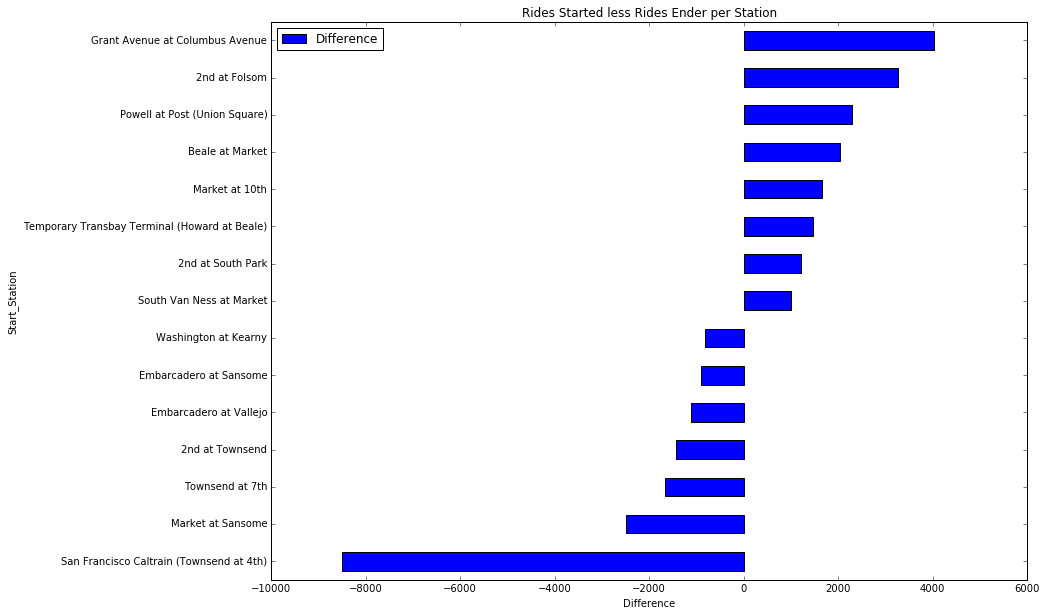

In [11]:
ax = diff.Trip_ID[diff.Trip_ID.abs() > 800].plot(kind='barh',figsize =(15,10), title = 'Rides Started less Rides Ender per Station',legend=True,label='Difference')
plt.gcf().subplots_adjust(left=0.20)
fig = ax.get_figure()
ax.set_xlabel("Difference")
fig.savefig('startstopdiff.png')

We learned from the above that there is significant single-directional traffic to or from certain stations.  
An 8000 trip difference in the case of the Caltrain station represents a significant.

In [12]:
status_indexed = status.copy()
status_indexed.index = (range(len(status)))

In [13]:
# Finding Number of Instances (minutes) the stations with the greateast positive trip difference had zero bikes
# * 2nd at Folsom is Terminal 62
# * Grant Avenue at Columus is 73
# * Powel at Post is 71
# * Temporary Transbay Terminal (Howard at Beale) is 55
# * Market at 10th 67
# * Beale at Market 56

folsom = status_indexed.groupby(['station_id', 'bikes_available']).get_group((62, 0)).bikes_available.count()
grant = status_indexed.groupby(['station_id', 'bikes_available']).get_group((73, 0)).bikes_available.count()
powel = status_indexed.groupby(['station_id', 'bikes_available']).get_group((71, 0)).bikes_available.count()
transbay = status_indexed.groupby(['station_id', 'bikes_available']).get_group((55, 0)).bikes_available.count()
tenth = status_indexed.groupby(['station_id', 'bikes_available']).get_group((67, 0)).bikes_available.count()
beale = transbay = status_indexed.groupby(['station_id', 'bikes_available']).get_group((56, 0)).bikes_available.count()

In [14]:
# Finding Number of Instances (minutes) the stations with the greateast negative trip difference had zero bikes
# * Townsend at 7th is 65
# * San Francisco Caltrain (Townsend at 4th) is 70
# * Market at Sansome is 77
# * 2nd at Townsend is 61
# * Embarcadero at Vallejo is 48
# * Embarcadero at Sansone is 60


townsend = status_indexed.groupby(['station_id', 'bikes_available']).get_group((65, 0)).bikes_available.count()
caltrain = status_indexed.groupby(['station_id', 'bikes_available']).get_group((70, 0)).bikes_available.count()
market = status_indexed.groupby(['station_id', 'bikes_available']).get_group((77, 0)).bikes_available.count()
second = status_indexed.groupby(['station_id', 'bikes_available']).get_group((61, 0)).bikes_available.count()
vallejo = status_indexed.groupby(['station_id', 'bikes_available']).get_group((48, 0)).bikes_available.count()
sansone = status_indexed.groupby(['station_id', 'bikes_available']).get_group((60, 0)).bikes_available.count()

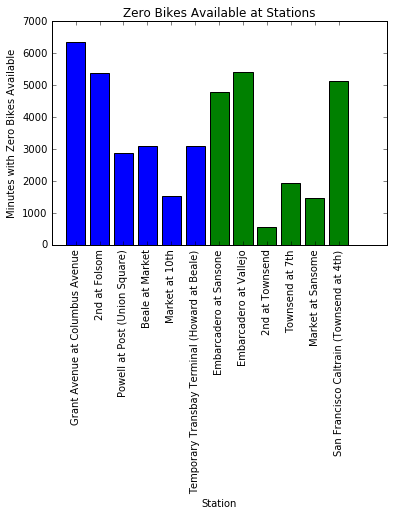

In [15]:
stations = [1,2,3,4,5,6,7,8,9,10,11,12]
no_bikes = [grant, folsom, powel, beale, tenth, transbay, sansone, vallejo, second, townsend, market, caltrain]

LABELS = ['Grant Avenue at Columbus Avenue', '2nd at Folsom', 'Powell at Post (Union Square)', 'Beale at Market', 'Market at 10th', 'Temporary Transbay Terminal (Howard at Beale)', 'Embarcadero at Sansone', 'Embarcadero at Vallejo', '2nd at Townsend' ,'Townsend at 7th', 'Market at Sansome','San Francisco Caltrain (Townsend at 4th)']
my_colors = ['b', 'b', 'b', 'b', 'b', 'b', 'g','g','g','g','g','g']
ax = plt.bar(stations, no_bikes, align='center', color = my_colors)
plt.xticks(stations, LABELS, rotation=90)
plt.title('Zero Bikes Available at Stations')
plt.xlabel('Station')
plt.ylabel('Minutes with Zero Bikes Available')
plt.show()


# line_up, = plt.plot([1,2,3], label='Line 2')
# line_down, = plt.plot([3,2,1], label='Line 1')
# plt.legend([line_up, line_down], ['Line Up', 'Line Down'])

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)

# figure = ax.get_figure()
# figure.savefig('no_bikes.png')
# won't save?

In [16]:
# Finding Number of Instances (minutes) the stations with the greateast positive trip difference had zero stations
# * 2nd at Folsom is Terminal 62
# * Grant Avenue at Columus is 73
# * Powel at Post is 71
# * Temporary Transbay Terminal (Howard at Beale) is 55
# * Market at 10th 67
# * Beale at Market 56

folsom1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((62, 0)).bikes_available.count()
grant1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((73, 0)).bikes_available.count()
powel1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((71, 0)).bikes_available.count()
transbay1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((55, 0)).bikes_available.count()
tenth1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((67, 0)).bikes_available.count()
beale1 = transbay = status_indexed.groupby(['station_id', 'docks_available']).get_group((56, 0)).bikes_available.count()

In [17]:
# Finding Number of Instances (minutes) the stations with the greateast negativezero stations trip difference had zero stations
# * Townsend at 7th is 65
# * San Francisco Caltrain (Townsend at 4th) is 70
# * Market at Sansome is 77
# * 2nd at Townsend is 61
# * Embarcadero at Vallejo is 48
# * Embarcadero at Sansone is 60


townsend1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((65, 0)).bikes_available.count()
caltrain1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((70, 0)).bikes_available.count()
market1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((77, 0)).bikes_available.count()
second1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((61, 0)).bikes_available.count()
vallejo1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((48, 0)).bikes_available.count()
sansone1 = status_indexed.groupby(['station_id', 'docks_available']).get_group((60, 0)).bikes_available.count()

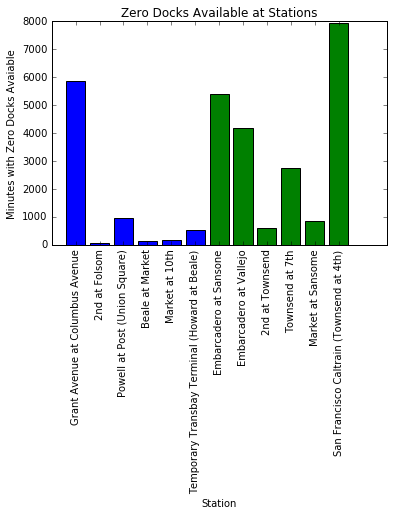

In [18]:
stations = [1,2,3,4,5,6,7,8,9,10,11,12]
no_bikes = [grant1, folsom1, powel1, beale1, tenth1, transbay1, sansone1, vallejo1, second1, townsend1, market1, caltrain1]

LABELS = ['Grant Avenue at Columbus Avenue', '2nd at Folsom', 'Powell at Post (Union Square)', 'Beale at Market', 'Market at 10th', 'Temporary Transbay Terminal (Howard at Beale)', 'Embarcadero at Sansone', 'Embarcadero at Vallejo', '2nd at Townsend' ,'Townsend at 7th', 'Market at Sansome','San Francisco Caltrain (Townsend at 4th)']
my_colors = ['b', 'b', 'b', 'b', 'b', 'b', 'g','g','g','g','g','g']
ax = plt.bar(stations, no_bikes, align='center', color = my_colors,)
plt.xticks(stations, LABELS, rotation=90)
plt.title('Zero Docks Available at Stations')
plt.xlabel('Station')
plt.ylabel('Minutes with Zero Docks Avaiable')
plt.show()